# Image Captioning
This model can generate short image summaries or caption for images. The model used MSCOCO dataset for training the model. 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import keras.backend as K
import keras.layers as L
import keras
from collections import defaultdict, Counter
import json
import pickle
import os
from nltk.tokenize import RegexpTokenizer
from skimage.io import imread
from skimage.transform import resize

%matplotlib inline

Using TensorFlow backend.


For this task, the first phase is extracting features from the images. For feature extraction we will use output from the penultimate layer of Inception v3 and use that for the RNN.

### Load the image features

In [2]:
# load training image features
with open('train_img_embeds.pickle', 'rb') as f:
    train_img_x = pickle.load(f)
# load the image file names
with open('train_img_fns.pickle', 'rb') as f:
    train_img_fnames = pickle.load(f)
    
# load validation image features
with open('val_img_embeds.pickle', 'rb') as f:
    val_img_x = pickle.load(f)
# load the validation image filenames
with open('val_img_fns.pickle', 'rb') as f:
    val_img_fnames = pickle.load(f)
    
print('Training: ', (train_img_x.shape, len(train_img_fnames)))
print('Validation: ', (val_img_x.shape, len(val_img_fnames)))

Training:  ((82783, 2048), 82783)
Validation:  ((40504, 2048), 40504)


In [3]:
print(train_img_fnames[1:3])
print()
print(train_img_x[1:5,:])

['COCO_train2014_000000101772.jpg', 'COCO_train2014_000000359320.jpg']

[[1.2160442  0.05921406 0.00597456 ... 0.73481756 0.01767585 0.13011375]
 [0.4107963  0.07758047 0.13539921 ... 0.752983   0.6687243  1.6961446 ]
 [0.557848   0.11978228 0.6715139  ... 1.5085114  0.41475642 0.0994454 ]
 [0.16797306 0.11785562 0.27388072 ... 0.68059987 0.17563528 0.01912199]]


### Load captions for images

***Content Structure of json file ***

`ann['images'][0]`
```
{'coco_url': 'http://mscoco.org/images/57870',
 'date_captured': '2013-11-14 16:28:13',
 'file_name': 'COCO_train2014_000000057870.jpg',
 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
 'height': 480,
 'id': 57870,
 'license': 5,
 'width': 640}
```

` ann['annotations'][0]`
 ```
 {'caption': 'A very clean and well decorated empty bathroom',
 'id': 48,
 'image_id': 318556}
```

` ann['info']`
 ```
 {'contributor': 'Microsoft COCO group',
 'date_created': '2015-01-27 09:11:52.357475',
 'description': 'This is stable 1.0 version of the 2014 MS COCO dataset.',
 'url': 'http://mscoco.org',
 'version': '1.0',
 'year': 2014}
```







In [0]:
'''
    loads captions for images
'''
def load_captions(filename, img_fnames):
    '''
    img_fnames: img file names
    filename: complete address of json file to load
    '''
    
    # load the json annotations file
    # ann contains three keys: info, images, licenses, annotations
    # info: contains info about image, its fullname name, id, h, w , url
    # annotations: caption, id, image_id
    with open(filename, 'r') as f:
        ann = json.load(f)
        
    # we already have a list of image file names, so we make another
    # list which contains the captions for those images, each image has atleast 5
    # captions or more
    
    # mapping from img filename to img id
    fname_to_id = {d['file_name']:d['id'] for d in ann['images']}
    
    # we first make a dict mapping for img file id to captions
    id_to_caption = defaultdict(list)
    for d in ann['annotations']:
        id_to_caption[d['image_id']].append(d['caption'])
    
    # for storing the captions
    captions = []
    
    # make the caption list
    for file_name in img_fnames:
        captions.append(id_to_caption[fname_to_id[file_name]])    
    
    return captions, {fname:id_to_caption[fname_to_id[fname]] for fname in fname_to_id.keys()}
    

In [7]:
train_cap, train_fname_caption = load_captions('annotations/captions_train2014.json', train_img_fnames)
print(len(train_cap))
val_cap, val_fname_caption = load_captions('annotations/captions_val2014.json', val_img_fnames)
print(len(val_cap))

82783
40504


In [12]:
train_cap[0]

['A long dirt road going through a forest.',
 'A SCENE OF WATER AND A PATH WAY',
 'A sandy path surrounded by trees leads to a beach.',
 'Ocean view through a dirt road surrounded by a forested area. ',
 'dirt path leading beneath barren trees to open plains']

A look at the training data

812 395


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


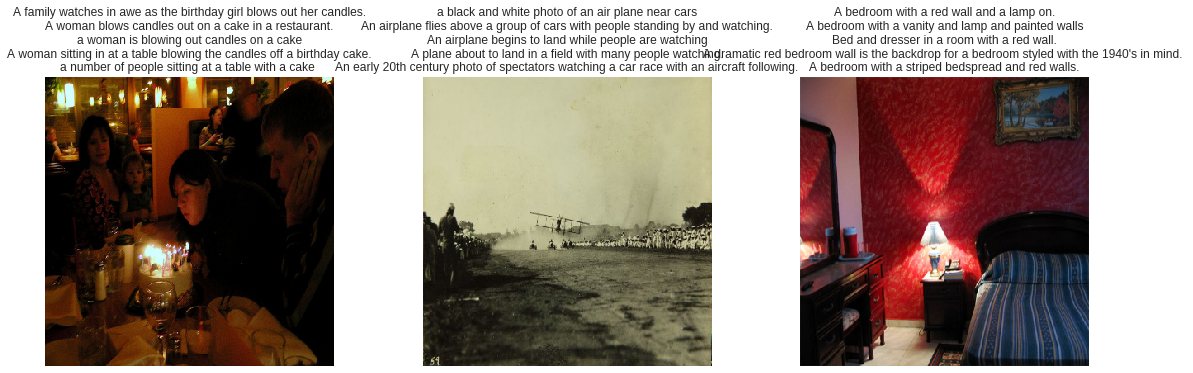

In [8]:
# for visualizing training data
files_train = os.listdir('train2014/')
files_val = os.listdir('val2014/')
print(len(files_train), len(files_val))

# training example
fig = plt.figure(figsize=(15,15))
for i in range(3):
    img = imread('train2014/' + files_train[i])
    img = resize(img, (350,350))
    fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plt.tight_layout()
    plt.imshow(img)
    plt.title('\n'.join(train_fname_caption[files_train[i]]))
plt.show()

## Text preprocessing
Before we can training the network the string captions needs to be in proper represenation for use.
Each string caption will need to represented in terms of numbers.
The folowing tokens have also been used for each of the captions:


```
<UNK>: Unknown word
<PAD>: For padding the empty places
<EOS>: End of Sentence
<START>: Begininng of a sentence
```



In [0]:
'''
    Builds vocabulary dict
'''
def create_text_utils(captions):
    
    # make list of unique tokens
    word_freq = Counter((' '.join([sent for capt_i in captions for sent in capt_i ])).split())
    # keep only top 6000 words 
    word_freq = word_freq.most_common(8000)
    
    # vocabulary list
    vocab,_ = list(zip(*word_freq))
    vocab = ['<UNK>','<PAD>','<EOS>','<START>'] + list(vocab)
    
    # make a vocabulary dictionary: word to index
    word_to_idx = defaultdict(int, {word:i for i,word in tqdm(enumerate(vocab))})
    
    # reverse dict
    idx_to_word = {word_to_idx[key]:key for key in word_to_idx.keys()}
    
    return word_to_idx, idx_to_word

In [10]:
# create the necessary mappings
word_to_idx, idx_to_word = create_text_utils(train_cap)

8004it [00:00, 1754806.82it/s]


In [0]:
# tokenizes the captions
def tokenize_captions(captions):
    # tokenize the sentences
    word_tokenizer = RegexpTokenizer(r'\w+')
    
    # tokenize captions
    captions_tokenized = []
    for i in range(len(captions)):
        captions_tokenized.append([])
        for j in range(len(captions[i])):
            captions_tokenized[i].append(word_tokenizer.tokenize(captions[i][j].lower()))
    
    return captions_tokenized

In [0]:
# tokenize captions
train_cap = tokenize_captions(train_cap)

In [0]:
# converts the string captions to its index representation and pads the caption
# if the size of a particular caption is less than the max length
def convert_to_num(captions, word_to_idx):
    
    # words to indices
    word_idx = []
    for i in range(len(captions)):
        word_idx.append([])
        for sent in captions[i]:
            word_idx[i].append([word_to_idx['<START>']] + [word_to_idx[word]
                                                           for word in sent] +
                              [word_to_idx['<EOS>']])
    
    return np.array(word_idx)

In [0]:
# adds padding to the numerical representaion of captions
# all the captions of all the examples in the arg batch are padded according to 
# the longest caption in the batch
def add_padding(word_idx):
    '''
        word_idx: (list(list)) list containing captions in indexed form as list.
    '''
    # find the maximum length amongst all the captions
    max_len = -99999999
    '''for i in range(len(word_idx)):
        print(word_idx[i])
        curr_max = max(map(len, word_idx[i]))
        max_len = max(max_len, curr_max)
    '''  
    max_len = max(map(len, word_idx))
    
    # Padded representation
    word_idx_pad = np.empty((len(word_idx), max_len), dtype='int32')
    word_idx_pad.fill(word_to_idx['<PAD>'])
    
    for i in range(len(word_idx)):
        #print(word_idx[i])
        word_idx_pad[i,:len(word_idx[i])] = word_idx[i]
    
    return np.array(word_idx_pad)

In [0]:
# convert the training captions to numerical index representation
train_cap = convert_to_num(train_cap, word_to_idx)

In [234]:
train_cap[0]

[[3, 4, 244, 236, 146, 261, 97, 4, 939, 2],
 [3, 4, 549, 7, 83, 11, 4, 787, 491, 2],
 [3, 4, 601, 787, 416, 46, 215, 2263, 14, 4, 115, 2],
 [3, 318, 165, 97, 4, 236, 146, 416, 46, 4, 3003, 156, 2],
 [3, 236, 787, 1093, 1087, 2852, 215, 14, 134, 3633, 2]]

In [235]:
add_padding(train_cap[0])

array([[   3,    4,  244,  236,  146,  261,   97,    4,  939,    2,    1,
           1,    1],
       [   3,    4,  549,    7,   83,   11,    4,  787,  491,    2,    1,
           1,    1],
       [   3,    4,  601,  787,  416,   46,  215, 2263,   14,    4,  115,
           2,    1],
       [   3,  318,  165,   97,    4,  236,  146,  416,   46,    4, 3003,
         156,    2],
       [   3,  236,  787, 1093, 1087, 2852,  215,   14,  134, 3633,    2,
           1,    1]], dtype=int32)

In [16]:
## find the length of longest caption 
max_len = -999999
for i in range(len(train_cap)):
    curr_max = max(map(len, train_cap[i]))
    max_len = max(max_len, curr_max)
print(max_len)

52


In [17]:
# no. of hidden state units
STATE_SIZE = 300
# dimension of word embedding to produce
WORD_EMBED_SIZE = 128
# dimension of encoding vector
IMG_ENC_SIZE = train_img_x.shape[1]
# batch size
BATCH_SIZE=512
# no. of batches to produce for 1 epoch
STEPS_PER_EPOCH = len(train_img_x)/BATCH_SIZE
# length of vocabulary
VOCAB_LEN = len(word_to_idx)
STEPS_PER_EPOCH

161.685546875

In [0]:
'''
    for generating random batches for model training
    train_img_x: numpy array containing img encoding values of shape(2048) for m examples
    train_cap: list of list ,training captions with each caption represented as 
                list of indices of the corresponding word
'''
def generate_model_batch(batch_size=BATCH_SIZE):
    while True:
        # pick out random indices for the batch
        indices = np.random.choice(len(train_img_x), batch_size, replace=False)
        # get the random batch of images
        batch_img_x = train_img_x[indices]
        # get the random batch of training captions
        # Since each image has atleast 5 captions, so we select randomly one each time
        batch_captions = [train_cap[idx][np.random.randint(5)] for idx in indices ]
        # now we pad the captions to equal length

        batch_captions = add_padding(batch_captions)

        # now the model gets two inputs: image encodings and captions
        # the output is captions shifted by one timestep
        # so to make things easier we send them as dict
        train_x = {
            'decoder_input': batch_captions[:, :-1],
            'hidden_state_input': batch_img_x
        }

        train_y = {
            'decoder_output': batch_captions[:, 1:]
        }

        yield (train_x, train_y)

In [0]:
data_generator = generate_model_batch(batch_size=BATCH_SIZE)

In [240]:
# check out the generated content
batch = next(data_generator)
batch_x = batch[0]
batch_y = batch[1]
print(batch_x)
print()
print(batch_y)

{'decoder_input': array([[   3,   22,  157, ...,    1,    1,    1],
       [   3,    4,   29, ...,    1,    1,    1],
       [   3,  184,   18, ...,    1,    1,    1],
       ...,
       [   3,    4,   13, ...,    1,    1,    1],
       [   3,    4,   67, ...,    1,    1,    1],
       [   3,    4, 4469, ...,    1,    1,    1]], dtype=int32), 'hidden_state_input': array([[0.16420758, 0.29665515, 0.1371282 , ..., 0.15177454, 0.07081525,
        0.7791251 ],
       [0.41369414, 0.34473196, 0.2094174 , ..., 0.39073843, 0.17663617,
        0.3482546 ],
       [0.31666982, 0.11461505, 0.39697543, ..., 0.57801855, 0.59300625,
        0.5346563 ],
       ...,
       [0.14216053, 0.3005773 , 0.94559795, ..., 0.8891724 , 0.18596609,
        0.52570224],
       [0.04291145, 0.7233949 , 0.3833983 , ..., 0.53004295, 1.4232688 ,
        0.511918  ],
       [0.65966636, 0.4687218 , 0.551299  , ..., 0.54844546, 0.04747527,
        0.1414273 ]], dtype=float32)}

{'decoder_output': array([[  22,  157, 

## Model Architecture

The model uses a two layer LSTM network. The idea is  to use the image as the values for the initial hidden states for the LSTM units. For that the image is represented as encoding of shape compatible with hidden state of LSTM units.


<img src="media/model_plot.png">

In [0]:
from keras.layers import Input, Embedding, Dense, LSTM, GRU
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

#### Global declaration of layers.

We will Keras functional API for building the model. For doing that , the layers need to be declared first globally.

In [0]:
# for taking the image encodings
hidden_state_input = Input(shape=(IMG_ENC_SIZE,), name='hidden_state_input')

# for converting the image encodings to desirable size matching the
# no. of LSTM hidden units
hidden_state_values = Dense(STATE_SIZE, activation='tanh',
                           name='hidden_state_values')

# for taking the captions as input
# None for the shape means that the length is not fixed for the captions
decoder_input = Input(shape=(None, ), name='decoder_input')

# For getting the embeddings out of captions
embedding_layer = Embedding(input_dim=VOCAB_LEN, output_dim=WORD_EMBED_SIZE,
                           name='embedding_layer')

# We will be using two layered LSTM network
# each layer needs to return the output sequence for the next layer stack
lstm_layer1 = LSTM(STATE_SIZE, name='lstm_layer1', return_sequences=True)
lstm_layer2 = LSTM(STATE_SIZE, name='lstm_layer2', return_sequences=True)

# the final output of the LSTM layer will pass through a dense layer
# Instead of using softmax loss, which would require the ground truth labels
# to be represented in One hot representation of length equal to vocabulary size, 
# we can use the sparse entropy loss, which internally converts the labels for 
# computing the loss, for that we need to write a custom loss, as the keras implementation 
# has bug issues with that.
decoder_dense_output = Dense(VOCAB_LEN, activation='linear', name='decoder_output')

#### Build the model

In [0]:
# add captions as input
caption_input = decoder_input
# connect embedding layer
caption_embeds = embedding_layer(caption_input)
# Initial hidden state
hidden_ini_states = hidden_state_values(hidden_state_input)

# pass the embeddings to the LSTM network
lstm1 = lstm_layer1(caption_embeds, initial_state=[hidden_ini_states,hidden_ini_states])
lstm2 = lstm_layer2(lstm1, initial_state=[hidden_ini_states,hidden_ini_states])

# pass the lstm output to dense layer
decoder_output = decoder_dense_output(lstm2)

# create keras model instance
model = Model(inputs=[hidden_state_input, decoder_input], 
                     outputs=[decoder_output])

In [244]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
hidden_state_input (InputLayer) (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, None, 128)    3347840     decoder_input[0][0]              
__________________________________________________________________________________________________
hidden_state_values (Dense)     (None, 300)          614700      hidden_state_input[0][0]         
__________________________________________________________________________________________________
lstm_layer

#### Loss function

In [0]:
'''
    Computes cross entropy loss between true labels(y_true) and predicted labels(y_pred)
'''
def sparse_cross_entropy(y_true, y_pred):
    
    # computes loss and outputs [batch_size, sequence_length] tensor
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                         logits=y_pred)
    mean_loss = tf.reduce_mean(loss)
    
    return mean_loss

#### Select Optimizer, Callbacks

In [0]:
# optimizer for the model
optimizer = RMSprop(lr=1e-3)

# for saving the weights 
checkpoint = ModelCheckpoint('drive/Colab Notebooks/checkpoint.keras', verbose=1,
                             save_weights_only=True)

# output dimensions for the model
# (bacth_size, arbitary sequence_length)
model_target = tf.placeholder(shape=(None, None), dtype='int32')

# compile the model with all this info
model.compile(optimizer=optimizer, loss=sparse_cross_entropy,
             target_tensors=[model_target])

## Training

In [31]:
# load if model is found
file_path = 'drive/Colab Notebooks/checkpoint.keras'
try:
    model.load_weights(file_path)
    print('Model weights loaded successfully')
except :
    print("Error !!.")

Model weights loaded successfully


The model was trained for 22 epochs and each took about 2 minutes to run.

In [0]:
hist = model.fit_generator(generator=generate_model_batch(batch_size=BATCH_SIZE),
                   steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=25, verbose=1, 
                   callbacks=[checkpoint])

### Training plots


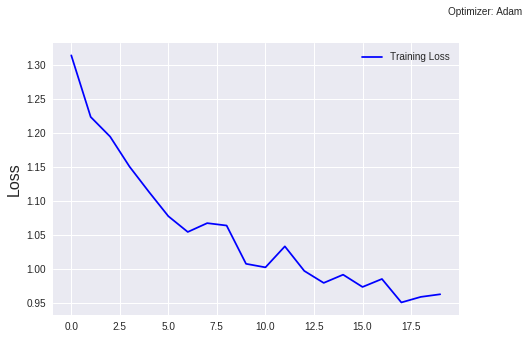

In [61]:
# loss plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.legend(loc='upper right')

plt.show()

### Helper Functions for Evaluation

In [32]:
# load the pretrained inception model in keras
image_model = InceptionV3(include_top=False)
image_model = keras.engine.training.Model(image_model.inputs, keras.layers.GlobalAveragePooling2D()(image_model.output))

87916544/87910968 [==============================] - 7s 0us/step


In [0]:
'''
    Load and encode the input image 
'''
def encode_image(file_name=None, path=True, img=None):
    # load and resize the image only when the path is provided
    if path:
        # read image
        img = load_img(file_name, target_size=(229, 229))
        # convert to numpy array
        img = img_to_array(img)
    
    # add another dimension that can act as the batch size 
    img = np.expand_dims(img, axis=0)
    # preprocess image
    img = preprocess_input(img)
    # get the model predictions
    pred = image_model.predict(img)
    
    return pred

In [0]:
"""
    Generates caption for the input image
"""
def generate_caption(image_path=None, max_tokens=35, path=True, img=None):
    
    # predicted caption for the input image
    caption = []
    # starting token
    curr_token = word_to_idx['<START>']
    # counter for the no. of words sampled
    token_counter = 0
    # <EOS> token index
    eos = word_to_idx['<EOS>']
    
    # if image path is provided
    if path == True:
        # get image encodings
        img_x = encode_image(file_name=image_path, path=True, img=None)
    else:
        # get image encodings
        img_x = encode_image(file_name=None, path=False, img=img)
        
    # dummy numpy array to feed to the model
    model_input_caption = np.empty(shape=(1, max_len), dtype='int32')
    # fill the input with padding
    model_input_caption.fill(word_to_idx['PAD'])

    # We will produce the caption by sampling. We start by feeding it <START> and the predicted
    # output word is then used as input for the next timestep. 
    # We do this till max_len is reached or <EOS> is encountered
    
    while curr_token != eos and token_counter < max_len:
        # For each word we feed the model the entire predicted sequence up till then
        # add the current token index in decoder input 
        model_input_caption[0, token_counter] = curr_token
        
        X = {
            'hidden_state_input': img_x,
            'decoder_input': model_input_caption
        }
        
        # predict the word 
        model_output = model.predict(X)
        
        # Since the output is One hot encoded, we pick the hot index 
        # get the current predicted word from one hot encoded output for the current timestep
        curr_token = np.argmax(model_output[0, token_counter, :])

        # add the currently predicted word
        caption.append(curr_token)

        token_counter += 1
    
    # check if last word is <EOS>
    if caption[-1] == eos:
        # remove the last <EOS> tag
        caption = caption[:-1]
    
    # convert the indices to words
    caption_word = [idx_to_word[idx] for idx in caption]
    
    return ' '.join(caption_word)

### Model Evaluation using Validation Images

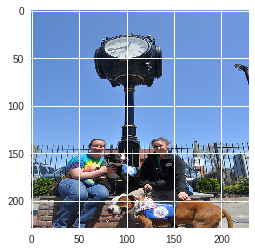

Predicted caption:
a group of people standing next to a clock



In [43]:
files_val = os.listdir('val2014/')

filename = files_val[np.random.randint(len(files_val))]
# read the image
img = load_img('val2014/'+filename, target_size=(229, 229))

# Plot the image.
plt.imshow(img)
plt.show()

# Print the predicted caption.
print("Predicted caption:")
output_text = generate_caption(image_path='val2014/'+filename, path=True, img=None)
print(output_text)
print()

### Validation Images Evaluation
We will now look at some of the predicted captions for validation images.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


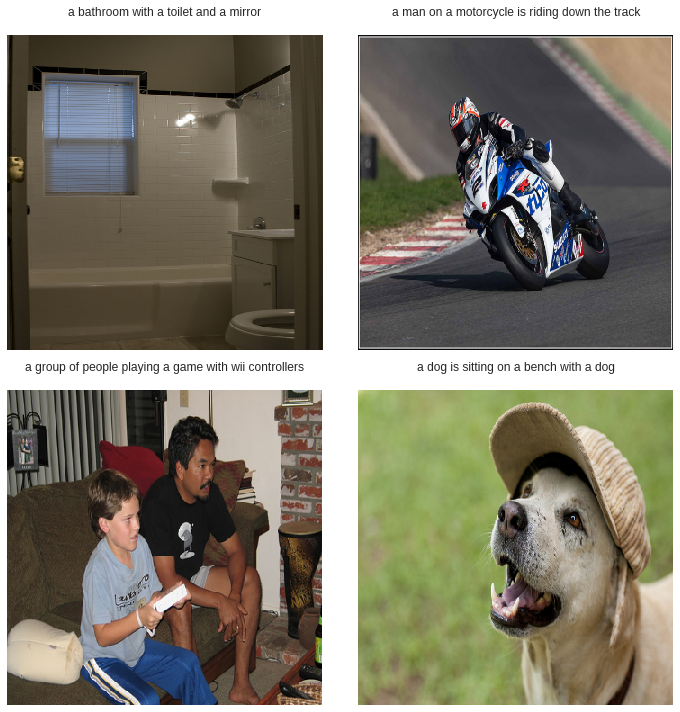

In [51]:
# for visualizing validation data
files_val = os.listdir('val2014/')

# Plot the validation images
fig = plt.figure(figsize=(10,10))
for i in range(4):
    img = imread('val2014/' + files_val[i])
    img = resize(img, (350,350))
    fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plt.tight_layout()
    plt.imshow(img)
    output_text = generate_caption(image_path='val2014/' + files_val[i], path=True, img = None)
    plt.title(output_text+'\n')
    
plt.show()